# Annotation stats

## Annotations by language
How many annotations are there by language?  
1. Use John Udell's [Facet](https://jonudell.info/h/facet/) to download annotations and replies.
2. Use langdetect to guess the language of highlighted text (_quote_) and, if available, of annotation (_text_) too. Get level of detection confidence, and use only above a certain threshold.

In [1]:
import pandas as pd
import langdetect
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/diegodlh/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Load downloaded annotations and replies
# data = pd.read_json('hypothesis.json')
# data['quote'] = data['prefix'] + data['exact'] + data['suffix']

data = pd.read_csv('dump_2020_05_07.csv')  # last 100,000 annotations on 2020-05-07
data.quote = data.quote.fillna('')
data.text = data.text.fillna('')

data.created = pd.to_datetime(data.created)
data.updated = pd.to_datetime(data.updated)

data['updated_date'] = data.updated.dt.date

In [3]:
## Sort users by their annotations
df = data.groupby('user').id.count()
df = df / df.sum() * 100
df = df.sort_values(ascending=False)
print(df)
del df

user
scibot          12.070143
TylerRick        2.321600
sciscore         1.780289
lmichan          1.415127
eng101           1.326063
                  ...    
drkhturner       0.000990
drkenty          0.000990
drgudinho        0.000990
dreadfulprof     0.000990
.AshM.           0.000990
Name: id, Length: 8584, dtype: float64


In [4]:
# Exclude specific users' annotations
exclude_users = ['sciscore', 'scibot']  # these bots were among the top annotators (see above)
data = data[~data.user.isin(exclude_users)]

In [5]:
# For the way how judell's facet works, urls seem to be retrieved by order of
# last annotation updated on them, but all annotations on that url
# are retrieved too. Therefore, there may be annotations not showing because the
# site they belong to hasn't been annotated recently, and older annotations which
# do show because there are recent annotations on the site where they are.

# find last annotation update in every url retrieved, and return the oldest of these update times
oldest_url = data.groupby('url', sort=False).updated.max().min()

# exclude annotations older than last updated url
data = data[data.updated >= oldest_url].reset_index(drop=True)

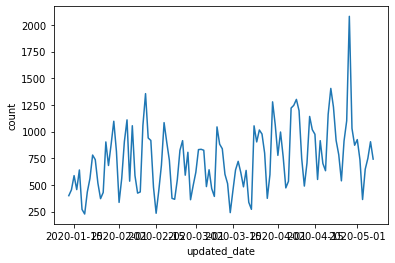

In [6]:
# number of annotations by last update
df = data.groupby(
    ['updated_date']
).agg(
    {'id': 'count'}
).reset_index(
    drop=False
).rename(
    {'id': 'count'}, axis='columns'
)

sns.lineplot(
    x="updated_date",
    y="count",
    data=df
)

del df

---

In [7]:
def detect_lang(string):
    # Provided a text string, return most likely language inferred and confidence score.
    # If no language can be inferred, return None with 0 score.
    import pdb
    import sys
    lang = None
    score = 0
    if string:
        try:
            main_lang = langdetect.detect_langs(string)[0]
            lang, score = str(main_lang).split(':')
            score = float(score)
        except langdetect.lang_detect_exception.LangDetectException as err:
            if not str(err) == 'No features in text.':
                print(err)
        except:
            pdb.set_trace()
    return lang, score

In [8]:
# Infer language for all annotations "quote" and "text".
# Save output.
# If output already saved, skip this step.
import os.path
from os import path

if not path.exists('out.csv'):
    # for col in ['title', 'quote', 'text']:
    for col in ['quote', 'text']:
        series = data[col]
        data[series.name + '_lang'], data[series.name + '_score'] = zip(*series.apply(detect_lang))
    data.to_csv('out.csv')
else:
    data = pd.read_csv('out.csv')
    data.created = pd.to_datetime(data.created)
    data.updated = pd.to_datetime(data.updated)

---

Number of annotations, by "quote" language detection score


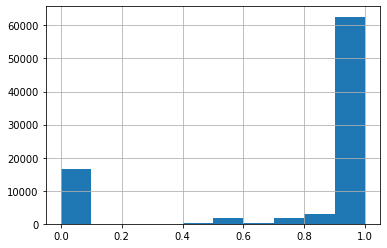

Number of annotations, by "text" language detection score


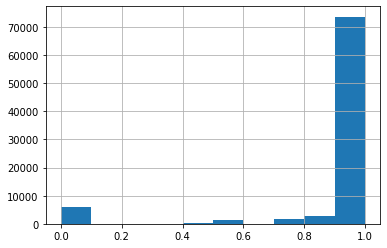

In [9]:
print('Number of annotations, by "quote" language detection score')
data.quote_score.hist()
plt.show()
print('Number of annotations, by "text" language detection score')
data.text_score.hist()
plt.show()

In [10]:
# percentage of annotations, by anchor language (quote_lang)

# exclude annotations with language detection score less than 95%
df = data[data.quote_score > .95].copy()

df2 = df.groupby('quote_lang').id.count() / len(df) * 100
print(df2.sort_values(ascending=False).head(10))
print()
print(
    '{:.2f}% of the {} annotations attached to anchors of language reliably detected (>95%) since {} were attached to anchors identified as Spanish'.format(
        df2['es'], len(df), df.updated.dt.date.min()
    )
)
del df, df2

quote_lang
en    77.984627
fr     6.527749
de     2.377794
es     1.941546
it     1.379057
nl     0.854919
ru     0.803784
pt     0.743061
ro     0.709503
ca     0.588057
Name: id, dtype: float64

1.94% of the 62579 annotations attached to anchors of language reliably detected (>95%) since 2020-01-13 were attached to anchors identified as Spanish


In [11]:
# number of annotated websites, by website language
df = data[data.quote_score > .95].copy()

# for each url, list all anchor languages detected
df = df.groupby('url', sort=False).quote_lang.apply(lambda x: x.unique())

# exclude urls for which more than one anchor language was detected
# i.e. keep only uniform-language-anchor urls
df2 = df[df.apply(lambda x: len(x)) == 1].apply(lambda x: x[0]).reset_index(drop=False)

print(
    'Of {} annotated sites whose annotations were attached to anchors of reliably detected language, \
{} had language-uniform anchors (i.e., anchors of only one language.)'.format(
        len(df), len(df2)
    )
)
print()

df3 = df2.groupby('quote_lang').url.count() / len(df2) * 100
print(df3.sort_values(ascending=False).head(10))
print()
print(
    '{:.2f}% of the {} annotated language-uniform websites (i.e., with annotation anchors in no more than 1 detected language) are in Spanish'.format(
        df3['es'], len(df2)
    )
)
del df, df2, df3

Of 12115 annotated sites whose annotations were attached to anchors of reliably detected language, 9884 had language-uniform anchors (i.e., anchors of only one language.)

quote_lang
en       84.399029
fr        2.681101
de        2.063942
es        1.932416
it        1.295022
ru        0.779037
zh-cn     0.617159
nl        0.566572
pt        0.515985
ro        0.465399
Name: url, dtype: float64

1.93% of the 9884 annotated language-uniform websites (i.e., with annotation anchors in no more than 1 detected language) are in Spanish


In [12]:
# percentage of annotations, by annotation language (text_lang)

df = data[data.text_score > .95].copy()

df2 = df.groupby('text_lang').id.count() / len(df) * 100
print(df2.sort_values(ascending=False).head(10))
print()
print(
    '{:.2f}% of the {} annotations of language reliably detected (>95%) since {} were written in Spanish'.format(
        df2['es'], len(df), df.updated.dt.date.min()
    )
)
del df, df2

text_lang
en    77.278961
fr     5.932836
es     5.018943
de     1.970370
it     1.124374
nl     0.941052
pt     0.822911
ru     0.803900
so     0.497006
af     0.430467
Name: id, dtype: float64

5.02% of the 73641 annotations of language reliably detected (>95%) since 2020-01-13 were written in Spanish


In [13]:
# What are the languages of the websites on which annotations in a certain language are made?

# keep only annotations anchored to quotes of at least 95% language detection confidence
# and with annotation text of at least 95% language detection confidence too
df = data[(data.quote_score > .95) & (data.text_score > .95)]

xtab = pd.crosstab(df.text_lang, df.quote_lang).apply(lambda x: round(100*x/x.sum()), axis=1)
# print(xtab)
print()
print('{:.2f}% of the annotations in Spanish were attached to Spanish quotes.'.format(xtab.loc['es', 'es']))
print('Whereas for English, this is {:.2f}% (i.e., percentage of English annotations attached to English quotes.)'.format(xtab.loc['en', 'en']))
del df


71.00% of the annotations in Spanish were attached to Spanish quotes.
Whereas for English, this is 91.00% (i.e., percentage of English annotations attached to English quotes.)


In [14]:
# percentage of users who annotated Spanish quotes

# number of annotations, per user and annotation quote language
df = data[data.quote_score > .95].pivot_table(values='id', index='user', columns='quote_lang', aggfunc='any')

# percentage of users per annotation quote language
# percentages will sum over 100% because some users may annotate quotes in different languages
df2 = df.sum()/len(df)*100
print(df2.sort_values(ascending=False).head(10))
print()
print(
    '{:.2f}% of {} users annotated Spanish quotes.'.format(
        df2['es'], len(df)
    )
)
print()

# percentage of users who annotated ONLY Spanish quotes
monolingual = df.sum(axis=1) == 1

df3 = df[monolingual].sum()/len(df[monolingual])*100
print(df3.sort_values(ascending=False).head(10))
print()
print(
    '{:.2f}% of {} monolingual users annotated Spanish quotes.'.format(
        df3['es'], len(df[monolingual])
    )
)
del df, df2, df3

quote_lang
en    84.147386
fr     9.840046
de     7.169380
it     6.726650
es     5.198515
ro     4.241645
ca     3.598972
tl     3.156241
af     2.927735
nl     2.913453
dtype: float64

5.20% of 7002 users annotated Spanish quotes.

quote_lang
en       83.042254
fr        4.732394
es        2.572770
de        2.347418
it        1.183099
pt        0.732394
id        0.450704
nl        0.431925
zh-cn     0.375587
ca        0.356808
dtype: float64

2.57% of 5325 monolingual users annotated Spanish quotes.


In [15]:
# percentage of users who annotated in Spanish

# number of annotations, per user and annotation text language
df = data[data.text_score > .95].pivot_table(values='id', index='user', columns='text_lang', aggfunc='any')

# percentage of users per annotation text language
# percentages will sum over 100% because some users may write annotations in different languages
df2 = df.sum()/len(df)*100
print(df2.sort_values(ascending=False).head(10))
print()
print(
    '{:.2f}% of {} users annotated in Spanish.'.format(
        df2['es'], len(df)
    )
)
print()

# percentage of users who annotated ONLY in Spanish
monolingual = df.sum(axis=1) == 1

df3 = df[monolingual].sum()/len(df[monolingual])*100
print(df3.sort_values(ascending=False).head(10))
print()
print(
    '{:.2f}% of {} monolingual users annotated in Spanish.'.format(
        df3['es'], len(df[monolingual])
    )
)
del df, df2, df3

text_lang
en    81.230022
fr     7.812300
es     4.756425
de     4.308912
it     3.452244
et     2.416571
id     2.071346
ro     2.032988
pt     1.956272
af     1.943485
dtype: float64

4.76% of 7821 users annotated in Spanish.

text_lang
en    80.873904
fr     4.717266
es     3.416994
de     2.479589
id     1.179317
et     1.103719
pt     0.710614
it     0.695494
tr     0.423344
cy     0.362867
dtype: float64

3.42% of 6614 monolingual users annotated in Spanish.


Monolingual rate (i.e., number of monolingual vs total annotators) is higher when looking at the language in which annotations are written, than when looking at the language of the anchors they are attached to.

This suggests that people may tend to annotate in their native language when reading in a foreign language.

Percentage of the population which speaks a second langugage seems an elusive figure.  
There is the [EF EPI (English Proficiency Index)](https://en.wikipedia.org/wiki/EF_English_Proficiency_Index), but it is seriously biased, because of participant autoselection.  
Argentina has some data, but it is outdated. In a [survey from 2006 (Spanish only)](https://www.pagina12.com.ar/diario/sociedad/3-78287-2006-12-27.html), 50% of people reported to know a foreign language, 85% of whom said it was English.
Percentage of people in the US who speak a second language would be [around roughly 20%](https://www.washingtonpost.com/local/education/half-the-world-is-bilingual-whats-our-problem/2019/04/24/1c2b0cc2-6625-11e9-a1b6-b29b90efa879_story.html).
Europe also has [some data of their own](https://ec.europa.eu/eurostat/statistics-explained/index.php/Foreign_language_skills_statistics). In 2016, 65% of the European population knew a second language, with percentages ranging from almost 100% in Sweden, to hardly 35% in the UK.
Data may therefore be out there, but it seems to be disperse, and non-systematic.

---

In [16]:
# ## top-20 of Spanish-speaking annotators
# df = data[(data.text_score > .95) & (data.text_lang == 'es')].reset_index(drop=True)

# # by number of annotations
# print(df.groupby('user').id.count().sort_values(ascending=False).head(20))

# # by number of annotated websites
# df.groupby('user').url.apply(lambda x: len(x.unique())).sort_values(ascending=False).head(20)